In [ ]:
!pip install transformers
!conda install -c anaconda nltk
!conda install -c conda-forge wordcloud
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.1 MB/s eta 0:00:00
/bin/bash: conda: command not found
/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import libraries
import numpy as np
from scipy import stats
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")


In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Conduct an exploratory screening of the dataset provided

dfv = pd.read_excel("/content/drive/MyDrive/Minmin 506/Project/redditPosts_v4.xlsx", sheet_name='Vaccinated')
dfu = pd.read_excel("/content/drive/MyDrive/Minmin 506/Project/redditPosts_v4.xlsx", sheet_name='Unvaccinated')
#print("No. of variables = ",len(df.columns))
#print("No. of records = ",len(df))

In [ ]:
dfv['Vaccinated'] = 1
dfu['Vaccinated'] = 0
df = pd.concat([dfv, dfu])

In [ ]:
df.head()

,Sno,Title,Author,Post ID,URL,Post text,data,Vaccinated
0,0,"Fully vaccinated and 3 years not getting it, n...",Womble-Tomble,11azh0p,https://www.reddit.com/r/COVID19positive/comme...,"Oh folks, I feel like being smashed to a wall....","Fully vaccinated and 3 years not getting it, n...",1
1,1,Fully vaccinated but got covid with severe sym...,froge_on_a_leaf,10qcxbu,https://www.reddit.com/r/COVID19positive/comme...,"Sorry for venting, I'm (23F) just trying to un...",Fully vaccinated but got covid with severe sym...,1
2,2,My experience with COVID-19 (17F double vaccin...,bloobblub,116cmzn,https://www.reddit.com/r/COVID19positive/comme...,This was my first time getting the virus since...,My experience with COVID-19 (17F double vaccin...,1
3,3,"vaccinated twice, first time infected, lacerat...",vreevroow,10sjdv9,https://www.reddit.com/r/COVID19positive/comme...,Every time I swallow I throw up. The vomit wor...,"vaccinated twice, first time infected, lacerat...",1
4,4,Fully Vaccinated with Booster 1 month ago. Hor...,613Flyer,z115fs,https://www.reddit.com/r/COVID19positive/comme...,I have had my vaccination and 2 boosters with ...,Fully Vaccinated with Booster 1 month ago. Hor...,1


In [ ]:
df1 = df[['data',	'Vaccinated']]
df1 = df1.dropna()
df1['data'] = df1['data'].astype(str).str.lower()
df1.head()

,data,Vaccinated
0,"fully vaccinated and 3 years not getting it, n...",1
1,fully vaccinated but got covid with severe sym...,1
2,my experience with covid-19 (17f double vaccin...,1
3,"vaccinated twice, first time infected, lacerat...",1
4,fully vaccinated with booster 1 month ago. hor...,1


In [ ]:
# check class distribution
df1['Vaccinated'].value_counts(normalize = True)

0    0.548861
1    0.451139
Name: Vaccinated, dtype: float64

In [ ]:
df1.isna().sum()

data          0
Vaccinated    0
dtype: int64

In [ ]:
from nltk.tokenize import RegexpTokenizer

regexp = RegexpTokenizer('\w+')

df1['text_token']=df1['data'].apply(regexp.tokenize)
df1.head(3)

,data,Vaccinated,text_token
0,"fully vaccinated and 3 years not getting it, n...",1,"[fully, vaccinated, and, 3, years, not, gettin..."
1,fully vaccinated but got covid with severe sym...,1,"[fully, vaccinated, but, got, covid, with, sev..."
2,my experience with covid-19 (17f double vaccin...,1,"[my, experience, with, covid, 19, 17f, double,..."


In [ ]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [ ]:
# Remove stopwords
df1['text_token'] = df1['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df1.head(3)

,data,Vaccinated,text_token
0,"fully vaccinated and 3 years not getting it, n...",1,"[fully, vaccinated, 3, years, getting, positve..."
1,fully vaccinated but got covid with severe sym...,1,"[fully, vaccinated, got, covid, severe, sympto..."
2,my experience with covid-19 (17f double vaccin...,1,"[experience, covid, 19, 17f, double, vaccinate..."


In [ ]:
#Remove infrequent words
df1['text_string'] = df1['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df1.head()

,data,Vaccinated,text_token,text_string
0,"fully vaccinated and 3 years not getting it, n...",1,"[fully, vaccinated, 3, years, getting, positve...",fully vaccinated years getting positve sick fo...
1,fully vaccinated but got covid with severe sym...,1,"[fully, vaccinated, got, covid, severe, sympto...",fully vaccinated got covid severe symptoms sor...
2,my experience with covid-19 (17f double vaccin...,1,"[experience, covid, 19, 17f, double, vaccinate...",experience covid 17f double vaccinated pfizer ...
3,"vaccinated twice, first time infected, lacerat...",1,"[vaccinated, twice, first, time, infected, lac...",vaccinated twice first time infected laceratio...
4,fully vaccinated with booster 1 month ago. hor...,1,"[fully, vaccinated, booster, 1, month, ago, ho...",fully vaccinated booster month ago horrid symp...


In [ ]:
#Create a list of all words
all_words = ' '.join([word for word in df1['text_string']])

In [ ]:
#Tokenize all_words
import nltk
nltk.download('punkt')

tokenized_words = nltk.tokenize.word_tokenize(all_words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'day': 2584, 'positive': 2448, 'covid': 2296, 'symptoms': 1770, 'tested': 1720, 'vaccinated': 1449, 'still': 1393, 'get': 1328, 'got': 1321, 'like': 1289, ...})

In [ ]:
df1['text_string_fdist'] = df1['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 5 ]))

In [ ]:
df1.head()

,data,Vaccinated,text_token,text_string,text_string_fdist
0,"fully vaccinated and 3 years not getting it, n...",1,"[fully, vaccinated, 3, years, getting, positve...",fully vaccinated years getting positve sick fo...,fully vaccinated years getting sick folks feel...
1,fully vaccinated but got covid with severe sym...,1,"[fully, vaccinated, got, covid, severe, sympto...",fully vaccinated got covid severe symptoms sor...,fully vaccinated got covid severe symptoms sor...
2,my experience with covid-19 (17f double vaccin...,1,"[experience, covid, 19, 17f, double, vaccinate...",experience covid 17f double vaccinated pfizer ...,experience covid double vaccinated pfizer deve...
3,"vaccinated twice, first time infected, lacerat...",1,"[vaccinated, twice, first, time, infected, lac...",vaccinated twice first time infected laceratio...,vaccinated twice first time infected throat ea...
4,fully vaccinated with booster 1 month ago. hor...,1,"[fully, vaccinated, booster, 1, month, ago, ho...",fully vaccinated booster month ago horrid symp...,fully vaccinated booster month ago symptoms an...


In [ ]:
#Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.stem import WordNetLemmatizer

wordnet_lem = WordNetLemmatizer()

df1['text_string_lem'] = df1['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [ ]:
# check if the columns are equal
df1['is_equal']= (df1['text_string_fdist']==df1['text_string_lem'])

In [ ]:
# show level count
df1.is_equal.value_counts()

True    1361
Name: is_equal, dtype: int64

In [ ]:
#Word cloud
all_words_lem = ' '.join([word for word in df1['text_string_lem']])

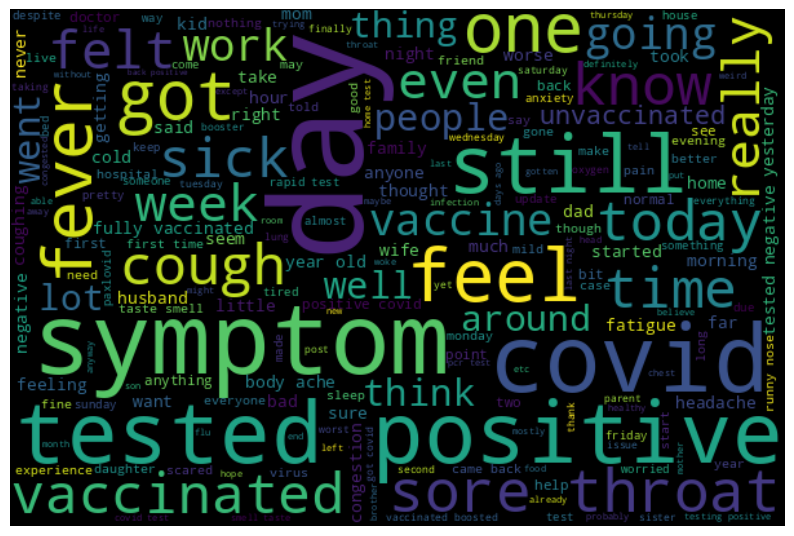

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600,
                     height=400,
                     random_state=2,
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

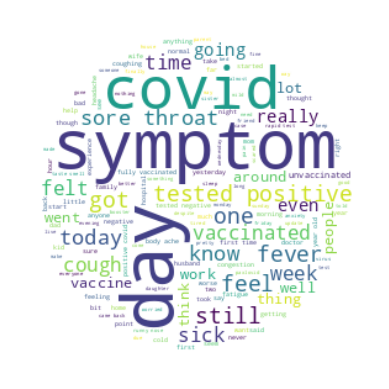

In [ ]:
import numpy as np

x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.generate(all_words_lem)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear");

In [ ]:
#Frequency distributions
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words = nltk.word_tokenize(all_words_lem)
fd = FreqDist(words)

In [ ]:
fd.most_common(20)

[('day', 2584),
 ('positive', 2448),
 ('covid', 2296),
 ('symptoms', 1770),
 ('tested', 1720),
 ('vaccinated', 1449),
 ('still', 1393),
 ('get', 1328),
 ('got', 1319),
 ('like', 1289),
 ('fever', 1218),
 ('test', 1153),
 ('days', 1111),
 ('throat', 1035),
 ('back', 979),
 ('time', 973),
 ('cough', 910),
 ('negative', 909),
 ('feel', 898),
 ('feeling', 871)]

In [ ]:
fd.tabulate(20)

       day   positive      covid   symptoms     tested vaccinated      still        get        got       like      fever       test       days     throat       back       time      cough   negative       feel    feeling 
      2584       2448       2296       1770       1720       1449       1393       1328       1319       1289       1218       1153       1111       1035        979        973        910        909        898        871 


In [ ]:
#Plot common words
# Obtain top 10 words
top_20 = fd.most_common(20)

# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_20))

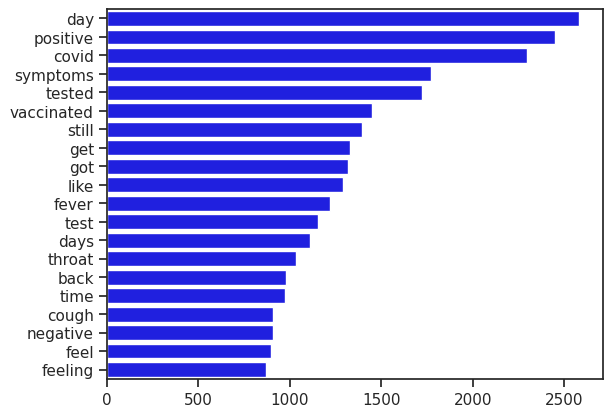

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.barplot(y=fdist.index, x=fdist.values, color='blue');

In [ ]:
import plotly.express as px

fig = px.bar(y=fdist.index, x=fdist.values)

# sort values
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})

# show plot
fig.show()

In [ ]:
# Show frequency of a specific word
fd["fever"]

1218

Sentiment analysis

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [ ]:
df1['polarity'] = df1['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
df1.tail(3)

,data,Vaccinated,text_token,text_string,text_string_fdist,text_string_lem,is_equal,polarity
744,"whole family positive \nhello guys,\nso i test...",0,"[whole, family, positive, hello, guys, tested,...",whole family positive hello guys tested positi...,whole family positive hello guys tested positi...,whole family positive hello guys tested positi...,True,"{'neg': 0.14, 'neu': 0.603, 'pos': 0.256, 'com..."
745,share your or your loved ones’ experiences wit...,0,"[share, loved, ones, experiences, hospitalized...",share loved ones experiences hospitalized covi...,share loved ones experiences hospitalized covi...,share loved ones experiences hospitalized covi...,True,"{'neg': 0.113, 'neu': 0.73, 'pos': 0.157, 'com..."
746,should i take my kids for another test? \nmy t...,0,"[take, kids, another, test, two, boys, 13, vac...",take kids another test two boys vaccinated cam...,take kids another test two boys vaccinated cam...,take kids another test two boys vaccinated cam...,True,"{'neg': 0.164, 'neu': 0.741, 'pos': 0.095, 'co..."


In [ ]:
# Change data structure
df2 = pd.concat(
    [df1.drop(['polarity'], axis=1),
     df1['polarity'].apply(pd.Series)], axis=1)
df2.head(3)

,data,Vaccinated,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound
0,"fully vaccinated and 3 years not getting it, n...",1,"[fully, vaccinated, 3, years, getting, positve...",fully vaccinated years getting positve sick fo...,fully vaccinated years getting sick folks feel...,fully vaccinated years getting sick folks feel...,True,0.289,0.511,0.201,-0.6694
1,fully vaccinated but got covid with severe sym...,1,"[fully, vaccinated, got, covid, severe, sympto...",fully vaccinated got covid severe symptoms sor...,fully vaccinated got covid severe symptoms sor...,fully vaccinated got covid severe symptoms sor...,True,0.106,0.705,0.189,0.8411
2,my experience with covid-19 (17f double vaccin...,1,"[experience, covid, 19, 17f, double, vaccinate...",experience covid 17f double vaccinated pfizer ...,experience covid double vaccinated pfizer deve...,experience covid double vaccinated pfizer deve...,True,0.260,0.648,0.091,-0.9930


In [ ]:
# Create new variable with sentiment "neutral," "positive" and "negative"
df2['sentiment'] = df2['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df2.head(4)

,data,Vaccinated,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment
0,"fully vaccinated and 3 years not getting it, n...",1,"[fully, vaccinated, 3, years, getting, positve...",fully vaccinated years getting positve sick fo...,fully vaccinated years getting sick folks feel...,fully vaccinated years getting sick folks feel...,True,0.289,0.511,0.201,-0.6694,negative
1,fully vaccinated but got covid with severe sym...,1,"[fully, vaccinated, got, covid, severe, sympto...",fully vaccinated got covid severe symptoms sor...,fully vaccinated got covid severe symptoms sor...,fully vaccinated got covid severe symptoms sor...,True,0.106,0.705,0.189,0.8411,positive
2,my experience with covid-19 (17f double vaccin...,1,"[experience, covid, 19, 17f, double, vaccinate...",experience covid 17f double vaccinated pfizer ...,experience covid double vaccinated pfizer deve...,experience covid double vaccinated pfizer deve...,True,0.260,0.648,0.091,-0.9930,negative
3,"vaccinated twice, first time infected, lacerat...",1,"[vaccinated, twice, first, time, infected, lac...",vaccinated twice first time infected laceratio...,vaccinated twice first time infected throat ea...,vaccinated twice first time infected throat ea...,True,0.253,0.666,0.081,-0.8979,negative


In [ ]:
df2u = df2[df2['Vaccinated'] == 0]
df2v = df2[df2['Vaccinated'] == 1]


In [ ]:
df2u.to_excel("/content/drive/MyDrive/Minmin 506/Project/tokenu.xlsx", index=False)
df2v.to_excel("/content/drive/MyDrive/Minmin 506/Project/tokenv.xlsx", index=False)

In [ ]:
df2v.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data               614 non-null    object 
 1   Vaccinated         614 non-null    int64  
 2   text_token         614 non-null    object 
 3   text_string        614 non-null    object 
 4   text_string_fdist  614 non-null    object 
 5   text_string_lem    614 non-null    object 
 6   is_equal           614 non-null    bool   
 7   neg                614 non-null    float64
 8   neu                614 non-null    float64
 9   pos                614 non-null    float64
 10  compound           614 non-null    float64
 11  sentiment          614 non-null    object 
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 58.2+ KB


Text(0.5, 1.0, 'Unvaccinated')

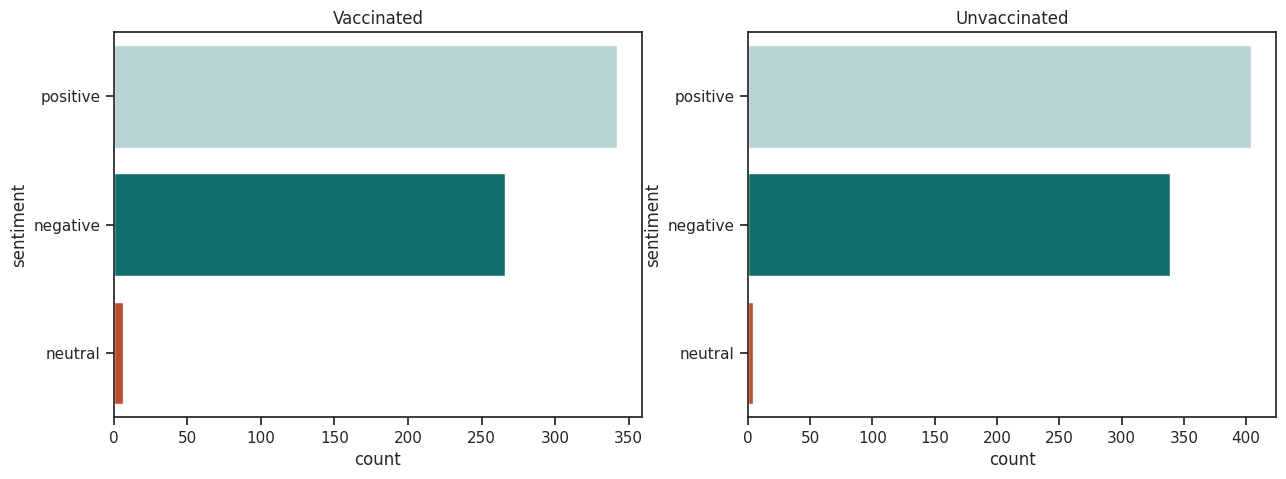

In [ ]:
# Number of tweets
sorder = ["positive", "negative", "neutral"]
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

sns.countplot(y='sentiment', data=df2v, order = sorder, palette=['#b2d8d8',"#008080", '#db3d13'], ax=axs[0]).set_title('Vaccinated')
sns.countplot(y='sentiment', data=df2u, order = sorder, palette=['#b2d8d8',"#008080", '#db3d13'], ax=axs[1]).set_title('Unvaccinated')



In [ ]:
df2v['sentiment'].value_counts()

positive    342
negative    266
neutral       6
Name: sentiment, dtype: int64

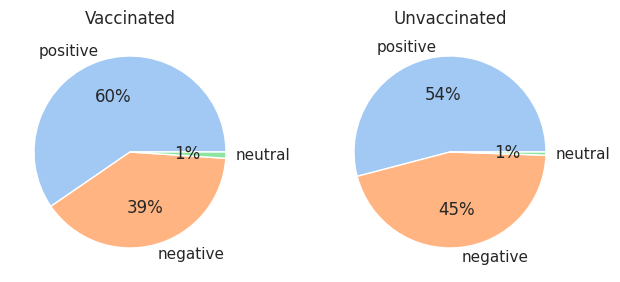

In [ ]:
sentiment_p = ['positive', 'negative', 'neutral']
sentiment_v = [342, 226, 6]
sentiment_u = [404, 339, 4]

colors = sns.color_palette('pastel')[0:3]
fig = plt.figure()

ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
ax1.pie(sentiment_v, labels = sentiment_p, colors = colors, autopct='%.0f%%')
ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
ax2.pie(sentiment_u, labels = sentiment_p, colors = colors, autopct='%.0f%%')
ax1.set_title('Vaccinated')
ax2.set_title('Unvaccinated')
plt.show()


Text(0.5, 1.0, 'Unvaccinated')

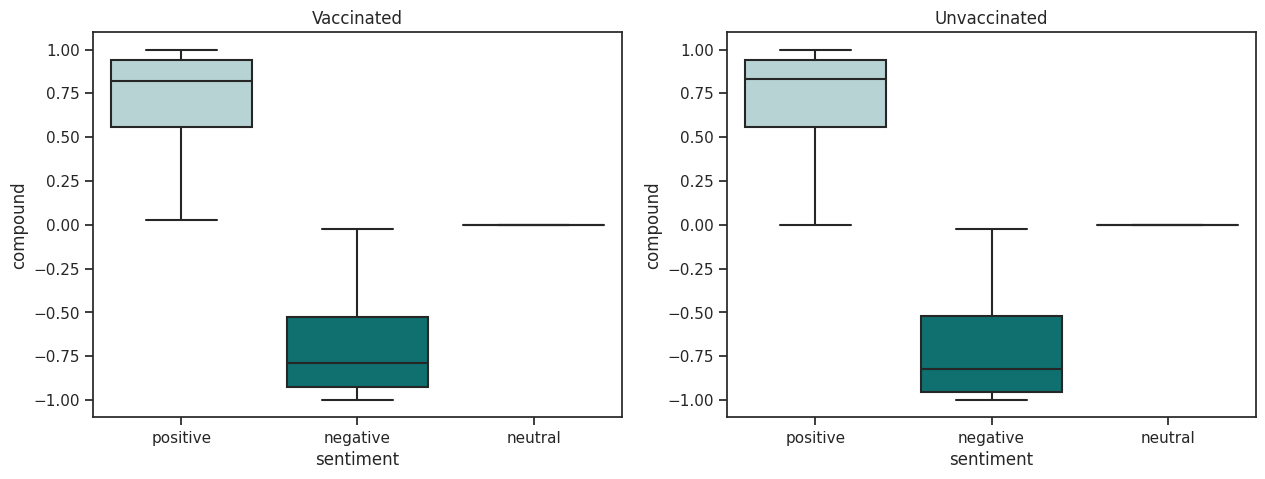

In [ ]:
# Boxplot
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.boxplot(y='compound', x='sentiment', palette=['#b2d8d8',"#008080", '#db3d13'], data=df2v, order = sorder, ax=axs[0]).set_title('Vaccinated')
sns.boxplot(y='compound', x='sentiment', palette=['#b2d8d8',"#008080", '#db3d13'], data=df2u, order = sorder, ax=axs[1]).set_title('Unvaccinated')



In [ ]:
import plotly.express as px

fig = px.bar(y=fdist.index, x=fdist.values)

# sort values
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})

# show plot
fig.show()

In [ ]:
all_words_lem_v = ' '.join([word for word in df2v['text_string_lem']])
all_words_lem_u = ' '.join([word for word in df2u['text_string_lem']])

In [ ]:
words_v = nltk.word_tokenize(all_words_lem_v)
fd_v = FreqDist(words_v)

words_u = nltk.word_tokenize(all_words_lem_u)
fd_u = FreqDist(words_u)

In [ ]:
fd_v.most_common(200)


[('positive', 1079),
 ('day', 1065),
 ('covid', 1033),
 ('symptoms', 776),
 ('tested', 727),
 ('vaccinated', 695),
 ('got', 572),
 ('still', 570),
 ('get', 555),
 ('test', 529),
 ('like', 521),
 ('fever', 507),
 ('days', 474),
 ('throat', 452),
 ('time', 421),
 ('negative', 420),
 ('cough', 404),
 ('back', 400),
 ('feeling', 344),
 ('sore', 342),
 ('feel', 335),
 ('first', 326),
 ('sick', 297),
 ('also', 297),
 ('today', 286),
 ('last', 282),
 ('one', 281),
 ('night', 280),
 ('home', 280),
 ('since', 268),
 ('started', 267),
 ('mild', 262),
 ('around', 250),
 ('felt', 245),
 ('even', 243),
 ('getting', 242),
 ('congestion', 242),
 ('better', 241),
 ('work', 239),
 ('went', 236),
 ('know', 234),
 ('took', 232),
 ('fully', 231),
 ('really', 229),
 ('vaccine', 229),
 ('would', 227),
 ('smell', 225),
 ('week', 222),
 ('family', 215),
 ('headache', 211),
 ('taste', 208),
 ('much', 204),
 ('people', 201),
 ('morning', 199),
 ('two', 196),
 ('anyone', 192),
 ('going', 191),
 ('nose', 191),
 (

In [ ]:
fd_u.most_common(200)

[('day', 1519),
 ('positive', 1369),
 ('covid', 1263),
 ('symptoms', 994),
 ('tested', 993),
 ('still', 823),
 ('get', 773),
 ('like', 768),
 ('vaccinated', 754),
 ('got', 747),
 ('fever', 711),
 ('days', 637),
 ('test', 624),
 ('throat', 583),
 ('back', 579),
 ('feel', 563),
 ('time', 552),
 ('feeling', 527),
 ('cough', 506),
 ('negative', 489),
 ('also', 471),
 ('home', 431),
 ('one', 421),
 ('felt', 415),
 ('sick', 397),
 ('sore', 396),
 ('know', 381),
 ('really', 375),
 ('better', 375),
 ('first', 374),
 ('night', 373),
 ('went', 372),
 ('last', 371),
 ('today', 363),
 ('started', 356),
 ('unvaccinated', 355),
 ('getting', 343),
 ('much', 338),
 ('around', 335),
 ('even', 335),
 ('since', 329),
 ('smell', 325),
 ('body', 324),
 ('taste', 320),
 ('headache', 307),
 ('took', 307),
 ('would', 307),
 ('family', 302),
 ('bad', 297),
 ('mild', 295),
 ('going', 292),
 ('work', 287),
 ('people', 284),
 ('nose', 279),
 ('congestion', 278),
 ('week', 274),
 ('year', 271),
 ('morning', 271),


In [ ]:
sym_col = ['fever', 'throat', 'cough', 'sick', 'mild' ,'congestion', 'headache', 'bad', 'severe', 'aches', 'pain', 'cold', 'fatigue', 'anxiety', 'chills', 'runny', 'paxlovid']
#sym_v = df
v_sno = []
u_sno = []
for i in range(0, 17):
  a = (fd_v[sym_col[i]])
  v_sno.append(a)
  i+=1
print(v_sno)

for i in range(0, 17):
  a = (fd_u[sym_col[i]])
  u_sno.append(a)
  i+=1
print(u_sno)

[507, 452, 404, 297, 262, 242, 211, 177, 80, 157, 139, 159, 163, 71, 109, 81, 121]
[711, 583, 506, 397, 295, 278, 307, 297, 91, 246, 247, 228, 225, 146, 125, 123, 135]


In [ ]:
df_sym = pd.DataFrame(list(zip(sym_col, v_sno, u_sno)), columns =['symptom', 'vaccinated', 'unvaccinated'])
df_sym

,symptom,vaccinated,unvaccinated
0,fever,507,711
1,throat,452,583
2,cough,404,506
3,sick,297,397
4,mild,262,295
5,congestion,242,278
6,headache,211,307
7,bad,177,297
8,severe,80,91
9,aches,157,246


In [ ]:
df_sym['vaccinated%'] = df_sym['vaccinated']/len(df2v)
df_sym['unvaccinated%'] = df_sym['unvaccinated']/len(df2u)
df_sym

,symptom,vaccinated,unvaccinated,vaccinated%,unvaccinated%
0,fever,507,711,0.825733,0.951807
1,throat,452,583,0.736156,0.780455
2,cough,404,506,0.657980,0.677376
3,sick,297,397,0.483713,0.531459
4,mild,262,295,0.426710,0.394913
5,congestion,242,278,0.394137,0.372155
6,headache,211,307,0.343648,0.410977
7,bad,177,297,0.288274,0.397590
8,severe,80,91,0.130293,0.121821
9,aches,157,246,0.255700,0.329317


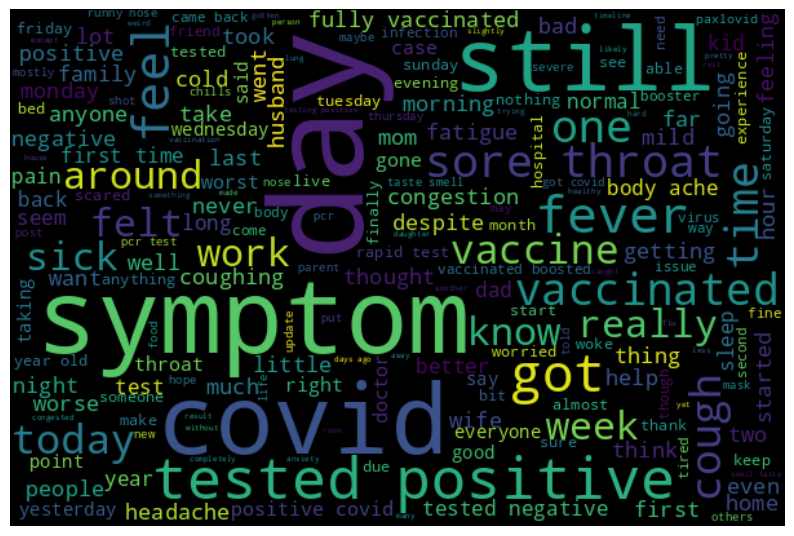

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600,
                     height=400,
                     random_state=2,
                     max_font_size=100).generate(all_words_lem_v)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

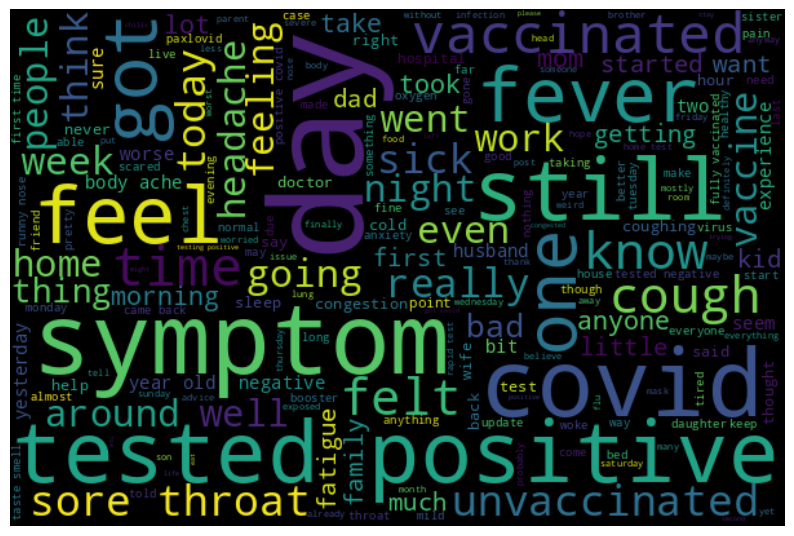

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=600,
                     height=400,
                     random_state=2,
                     max_font_size=100).generate(all_words_lem_u)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
pathv = '/content/drive/MyDrive/Minmin 506/Project/clean_vac.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df2v.to_csv(f)

pathv = '/content/drive/MyDrive/Minmin 506/Project/clean_unvac.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df2u.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: ignored